In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
work_dir = "drive/My Drive/Training Records 2/"
impl_type = "MultiModel.FOIU1.1"
dataset = "Fashion"

In [3]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import csv
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, LambdaCallback
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import CSVLogger

In [4]:
list_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(list_categories)
print('num_classes =', num_classes)

num_classes = 10


In [5]:
from sklearn.utils import shuffle

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, y_train = shuffle(x_train, y_train)

print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


In [6]:
x_train_norm = x_train/255
x_test_norm = x_test/255

In [7]:
final_train_imageset = np.expand_dims(x_train_norm, axis = 3)
final_test_imageset = np.expand_dims(x_test_norm, axis = 3)

y_train2 = np.expand_dims(y_train, axis = 1)
y_test2 = np.expand_dims(y_test, axis = 1)

print('final_train_imageset.shape =', final_train_imageset.shape)
print('final_test_imageset.shape =', final_test_imageset.shape)
print('y_train2.shape =', y_train2.shape)
print('y_test2.shape =', y_test2.shape)

final_train_imageset.shape = (60000, 28, 28, 1)
final_test_imageset.shape = (10000, 28, 28, 1)
y_train2.shape = (60000, 1)
y_test2.shape = (10000, 1)


In [8]:
final_train_label = tf.keras.utils.to_categorical(y_train2, num_classes)
final_test_label = tf.keras.utils.to_categorical(y_test2, num_classes)

print('final_train_label.shape =',final_train_label.shape)
print('final_test_label.shape =',final_test_label.shape)

final_train_label.shape = (60000, 10)
final_test_label.shape = (10000, 10)


In [24]:
sure_reset = True # True, False

if sure_reset == True:
    print(f"Resetting...")
    list_all_predicted = []
    individual_accuracies = []

    def identify_predicted_label(predicted_values):
        list_y_pred = []
        for pred_val_list in predicted_values:
            pred_val = np.where(pred_val_list == max(pred_val_list))
            list_y_pred.append(pred_val[0][0])
        list_all_predicted.append(np.array(list_y_pred))

        count_correct = 0
        for y_true,y_predicted in zip(y_test,list_y_pred):
            if y_true == y_predicted:
                count_correct += 1
        individual_accuracies.append(round((count_correct/len(list_y_pred))*100, 2))

        return list_all_predicted, individual_accuracies
    print(f"sure_reset = {sure_reset}")
elif sure_reset == False:
    print(f"sure_reset = {sure_reset}")

Resetting...
sure_reset = True


In [10]:
NUM_NEURONS = 32
NUM_LAYERS = 3
BATCH_SIZE = 128
NUM_EPOCHS = 5
#epochs_completed = 0
LEARNING_RATE = 0.0001
EPSILON = 1e-7
DROPOUT = 0.5
#MOMENTUM = 0.99

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'default' # 'relu' 'LeakyReLU' 'PReLU' 'ELU' 'default'
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
early_stop_after_epochs = 3

nTry = "lanczos3.1"
# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+"_dropout"+str(DROPOUT)+"_batch"+str(BATCH_SIZE)+".hdf5"
checkpointer_name  = "weights."+dataset+"."+impl_type+".batch"+str(BATCH_SIZE)+".nTry."+nTry
log_name = "log."+checkpointer_name[8:]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)

checkpointer_name = weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1
log_name = log.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1.log


In [11]:
#'''
act_func = tf.keras.layers.LeakyReLU(alpha=0.3)

input_shape = final_train_imageset.shape[1:]

inputs = Input(input_shape)
x = inputs
#units = 32
# bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic
x = experimental.preprocessing.Resizing(64, 64, 'lanczos3')(x)
print("x.shape =",x.shape)

x = Conv2D(32, (3,3), activation=act_func)(x)
x = Conv2D(32, (3,3), activation=act_func)(x)
x = Conv2D(32, (3,3), activation=act_func)(x)
x = Conv2D(32, (3,3), activation=act_func)(x)
x = Conv2D(32, (3,3), activation=act_func)(x)
x = Conv2D(32, (3,3), activation=act_func)(x)
x = Conv2D(32, (3,3), activation=act_func)(x)

x = Flatten()(x)
x = Dense(512, activation=act_func)(x)
x = Dropout(0.2)(x)

outputs = Dense(num_classes, activation=FINAL_ACTIVATION_FUNCTION)(x)

model = Model(inputs=inputs, outputs=outputs)
#model = Model(inputs=inputs_r, outputs=outputs)
#model.summary()
#'''

x.shape = (None, 64, 64, 1)


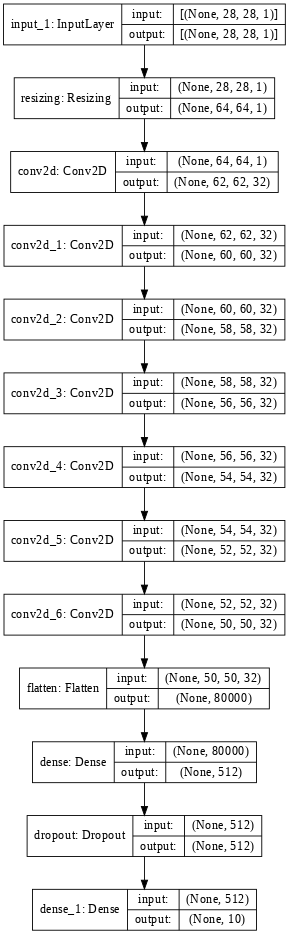

In [12]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)

In [13]:
optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
#optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=MOMENTUM)
#optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON)
model.compile(
    optimizer=optimizer, #'rmsprop',
    loss=LOSS,
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 0, 
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [15]:
def checkBestPerformance(epoch, logs):
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
    min_val_loss = min(log_data.val_loss.values)
    max_val_acc = max(log_data.val_accuracy.values)

    current_val_acc = logs['val_accuracy']
    current_val_loss = logs['val_loss']

    save_filepath = work_dir+"best_"+checkpointer_name
    if current_val_loss < min_val_loss:
        model.save(filepath = save_filepath)
        #print("\nval_loss decreased from", min_val_loss, "to", current_val_loss, ".")
        print("\nval_loss decreased to", current_val_loss, ".")

        #list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping]
        #print("\nReturned to previous best checkpoint callback.")

    elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
        model.save(filepath = save_filepath)
        #print("\nval_accuracy increased from", max_val_acc, "to", current_val_acc, ".")
        print("\nval_accuracy increased to", current_val_acc, ".")

        #list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping]
        #print("\nReturned to previous best checkpoint callback.")

    else:
        pass
        #print("\nPerformance did not improve from existing min_val_loss =", min_val_loss, ", max_val_acc =", max_val_acc, ".")
    #return

In [16]:
epochs_completed = 0
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    if epochs_completed > 0:
        model = load_model(work_dir+checkpointer_name)
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
except:
    list_callbacks = [checkpointer, checkpointer_best, csv_logger]

In [17]:
try:
    print(f"Previously trained individual_accuracies = {individual_accuracies}")
except:
    pass

In [18]:
print("Previously completed epochs =", epochs_completed, "\n")

start_time = time.time()
history = model.fit(final_train_imageset, final_train_label, 
                    shuffle=True, 
                    batch_size = BATCH_SIZE, 
                    epochs = NUM_EPOCHS - epochs_completed, 
                    #steps_per_epoch = 2,
                    #validation_split = validation_split, 
                    validation_data = (final_test_imageset, final_test_label),
                    callbacks=list_callbacks
                    )
elapsed_time = time.time() - start_time 
print("\nTime elapsed: ", elapsed_time)

Previously completed epochs = 0 

Epoch 1/5
469/469 [==============================] - 60s 109ms/step - loss: 0.5017 - accuracy: 0.8202 - val_loss: 0.3892 - val_accuracy: 0.8633


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets



Epoch 00001: val_loss improved from inf to 0.38925, saving model to drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


Epoch 2/5
469/469 [==============================] - 50s 106ms/step - loss: 0.3261 - accuracy: 0.8810 - val_loss: 0.3215 - val_accuracy: 0.8827


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets



Epoch 00002: val_loss improved from 0.38925 to 0.32155, saving model to drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


Epoch 3/5
469/469 [==============================] - 50s 106ms/step - loss: 0.2721 - accuracy: 0.9010 - val_loss: 0.2869 - val_accuracy: 0.8939


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets



Epoch 00003: val_loss improved from 0.32155 to 0.28691, saving model to drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


Epoch 4/5
469/469 [==============================] - 50s 106ms/step - loss: 0.2368 - accuracy: 0.9133 - val_loss: 0.2724 - val_accuracy: 0.9021


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets



Epoch 00004: val_loss improved from 0.28691 to 0.27237, saving model to drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


Epoch 5/5
469/469 [==============================] - 50s 106ms/step - loss: 0.2058 - accuracy: 0.9261 - val_loss: 0.2795 - val_accuracy: 0.9025


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets


INFO:tensorflow:Assets written to: drive/My Drive/Training Records 2/weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1/assets



Epoch 00005: val_loss did not improve from 0.27237

Time elapsed:  322.960636138916


In [19]:
result = model.evaluate(final_test_imageset, final_test_label)
print("Accuracy : {}, Loss: {}".format(result[1], result[0]))

313/313 [==============================] - 3s 10ms/step - loss: 0.2795 - accuracy: 0.9025
Accuracy : 0.9024999737739563, Loss: 0.2794512212276459


In [20]:
model_loaded = load_model(work_dir+"best_"+checkpointer_name)

In [21]:
result2 = model_loaded.evaluate(final_test_imageset, final_test_label)
print("{}: Test Acc: {}, Test Loss: {}".format("best_"+checkpointer_name, round(result2[1],4), round(result2[0],4) ))

313/313 [==============================] - 3s 10ms/step - loss: 0.2724 - accuracy: 0.9021
best_weights.Fashion.MultiModel.FOIU1.1.batch128.nTry.lanczos3.1: Test Acc: 0.9021, Test Loss: 0.2724


In [22]:
#predicted_values = model.predict_generator(final_test_imageset, len(final_test_imageset))
predicted_values = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [25]:
list_all_predicted, individual_accuracies = identify_predicted_label(predicted_values)

num_try = 1
np.save(f'{work_dir}list_all_predicted_Multimodal.{dataset}.{num_try}.pkl', list_all_predicted, allow_pickle=True)
np.save(f'{work_dir}individual_accuracies_Multimodal.{dataset}.{num_try}.pkl', individual_accuracies, allow_pickle=True)

list_all_predicted = list(np.load(f'{work_dir}list_all_predicted.{dataset}.{impl_type}.pkl.npy', allow_pickle=True))
individual_accuracies = list(np.load(f'{work_dir}individual_accuracies.{dataset}.{impl_type}.pkl.npy', allow_pickle=True))

In [26]:
max_index_ind_acc = np.argmax(np.array(individual_accuracies))

In [27]:
print(f"max_index_ind_acc = {max_index_ind_acc}")
print(f"len(list_all_predicted) = {len(list_all_predicted)}")
print(f"len(list_all_predicted[{max_index_ind_acc}]) = {len(list_all_predicted[max_index_ind_acc])}")
print(f"individual_accuracies = {individual_accuracies}")

max_index_ind_acc = 0
len(list_all_predicted) = 1
len(list_all_predicted[0]) = 10000
individual_accuracies = [90.21]


In [28]:
print("np.array(list_all_predicted).shape =", np.array(list_all_predicted).shape)
#np.array(list_all_predicted)

np.array(list_all_predicted).shape = (1, 10000)


In [29]:
from scipy import stats

list_modes = stats.mode(np.array(list_all_predicted))
print("list_modes.mode.shape =", list_modes.mode.shape)
list_modes

list_modes.mode.shape = (1, 10000)


ModeResult(mode=array([[9, 2, 1, ..., 8, 1, 5]]), count=array([[1, 1, 1, ..., 1, 1, 1]]))

In [30]:
'''
Final: correctly classified 9063 out of 10000. Accuracy = 90.63%
Final: correctly classified 9063 out of 10000. Accuracy = 90.63%
Final: correctly classified 9109 out of 10000. Accuracy = 91.09%
Final: correctly classified 9145 out of 10000. Accuracy = 91.45%

'''

'\nFinal: correctly classified 9063 out of 10000. Accuracy = 90.63%\nFinal: correctly classified 9063 out of 10000. Accuracy = 90.63%\nFinal: correctly classified 9109 out of 10000. Accuracy = 91.09%\nFinal: correctly classified 9145 out of 10000. Accuracy = 91.45%\n\n'

In [31]:
final_count_correct = 0
data = 0
final_prediction_list = []
for true,mode_val,freq in zip(y_test, list_modes.mode[0],list_modes.count[0]):
    #print(f"data {data}: true = {true}; mode = {mode}; count = {count}")
    if (true == mode_val) and (freq > 1):
        final_prediction_list.append(mode_val)
        final_count_correct += 1
    elif true == list_all_predicted[max_index_ind_acc][data]:
        final_prediction_list.append(list_all_predicted[max_index_ind_acc][data])
        final_count_correct += 1
    data += 1
    #break

print(f'Final: correctly classified {final_count_correct} out of {len(y_test)}. \
Accuracy = {round((final_count_correct/len(y_test))*100, 2)}%\n')
#print(f"Final accuracy = {round((final_count_correct/len(final_predictions))*100, 2)}%")

Final: correctly classified 9021 out of 10000. Accuracy = 90.21%



In [32]:
with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [33]:
#Confution Matrix and Classification Report
'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
#'''

"\nY_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))\ny_pred = np.argmax(Y_pred, axis=1)\nprint('Confusion Matrix')\nprint(confusion_matrix(y_test, y_pred))\n#"

In [34]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
'''
print('Classification Report:')
#target_names = ['Mono', 'Di'] # not ['Di', 'Mono']
print(classification_report(y_test, y_pred)) #, target_names=target_names))
#'''

"\nprint('Classification Report:')\n#target_names = ['Mono', 'Di'] # not ['Di', 'Mono']\nprint(classification_report(y_test, y_pred)) #, target_names=target_names))\n#"

In [35]:
'''
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=list_categories))
#'''

"\nprint('Classification Report')\nprint(classification_report(y_test, y_pred, target_names=list_categories))\n#"

In [36]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 
print("log_data.shape =", log_data.shape)

log_data.shape = (5, 5)


In [37]:
# Getting the model history keys 
#history.history.keys()
#log_data.head()

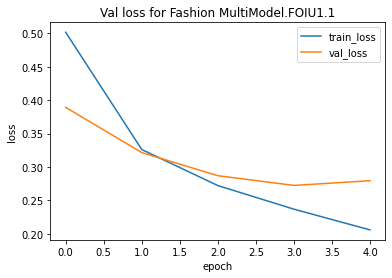

img_path = drive/My Drive/Training Records 2/Images/vLoss_Fashion.MultiModel.FOIU1.1.batch128.nTry.lancz.png


In [38]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
#plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

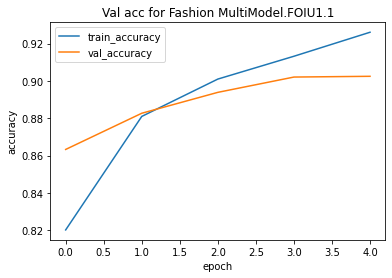

img_path = drive/My Drive/Training Records 2/Images/vAcc_Fashion.MultiModel.FOIU1.1.batch128.nTry.lancz.png


In [39]:
title = "Val acc for "+dataset+" "+impl_type

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
#plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)